In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, linear_model, metrics

from mlxtend.plotting import plot_decision_regions 
import tensorflow as tf

%matplotlib inline

/Users/abulbasar/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
import requests
url = "https://raw.githubusercontent.com/abulbasar/machine-learning/master/Utils.py"
exec(requests.get(url).text)

In [3]:
df_train = pd.read_csv("/data/MNIST/mnist_train.csv")
df_test = pd.read_csv("/data/MNIST/mnist_test.csv")

In [4]:
X_train = df_train.iloc[:, 1:].values.astype(np.float32)
X_test = df_test.iloc[:, 1:].values.astype(np.float32)

scaler = preprocessing.StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)
y_train = df_train.values[:, 0]
y_test = df_test.values[:, 0]

X Tensor("X:0", shape=(?, 784), dtype=float32)
y Tensor("y:0", shape=(?,), dtype=int32)
conv_layer1 Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
conv_layer2 Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
flat Tensor("Relu_2:0", shape=(?, 3136), dtype=float32)
y_pred Tensor("ArgMax:0", shape=(?,), dtype=int32)
0 training cost:  7.94528 training accuracy:  0.132812
75 training cost:  0.233602 training accuracy:  0.90625
150 training cost:  0.29047 training accuracy:  0.914062
225 training cost:  0.110516 training accuracy:  0.96875
300 training cost:  0.0960415 training accuracy:  0.96875
375 training cost:  0.0970077 training accuracy:  0.976562
450 training cost:  0.0799595 training accuracy:  0.960938
525 training cost:  0.0480687 training accuracy:  0.984375
600 training cost:  0.0492752 training accuracy:  0.984375
675 training cost:  0.105315 training accuracy:  0.96875
750 training cost:  0.0839091 training accuracy:  0.976562
825 training cost:  0.0673244 

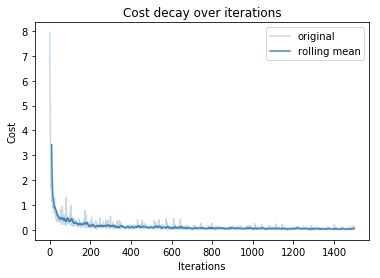

In [17]:
%%time

tf.reset_default_graph()
tf.set_random_seed(1)
n_x = X_train_std.shape[1]
n_y = 10
n_h = 200
max_iters = 1500
learning_rate = 0.001

X = tf.placeholder(dtype=tf.float32, shape=[None, n_x], name="X")
y = tf.placeholder(dtype=tf.int32, shape=[None], name="y")
keep_prob = tf.placeholder_with_default(input=1.0, shape=[])


y_oh = tf.one_hot(indices=y, depth=n_y)

X_image = tf.reshape(X, shape=[-1, 28, 28, 1])


print("X", X)
print("y", y)

def conv_layer(input, shape):
    W = tf.Variable(tf.truncated_normal(shape=shape, stddev=0.1))
    b = tf.Variable(tf.constant(0.1, shape=[shape[3]]))
    conv = tf.nn.conv2d(input, W, strides=[1, 1, 1, 1], padding="SAME")
    A = tf.nn.relu(conv + b)
    return tf.nn.max_pool(A, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


def full_layer(input, size, activation = None, keep_prob = None):
    input_size = int(input.get_shape()[1])
    W = tf.Variable(tf.truncated_normal(stddev=0.1, shape=[input_size, size]))
    b = tf.Variable(tf.constant(0.1, shape=[size]))
    Z = tf.matmul(input, W) + b
    if not activation is None:
        Z = activation(Z)
    
    if not keep_prob is None:
        Z = tf.nn.dropout(x=Z, keep_prob = keep_prob)
    return Z

conv_layer1 = conv_layer(X_image, [5, 5, 1, 32])
conv_layer2 = conv_layer(conv_layer1, [5, 5, 32, 64])
print("conv_layer1", conv_layer1)
print("conv_layer2", conv_layer2)

conv2_shape = conv_layer2.get_shape() 
s1 = conv2_shape[1] * conv2_shape[2] * conv2_shape[3]
flat = tf.nn.relu(tf.reshape(conv_layer2, [-1, s1]))
print("flat", flat)

full_layer_1 = full_layer(flat, n_h, activation = tf.nn.relu, 
                        keep_prob = keep_prob)
Z = full_layer(full_layer_1, n_y)

y_pred = tf.argmax(tf.nn.softmax(Z), axis=1, output_type=tf.int32) 
print("y_pred", y_pred)

accuracy = tf.reduce_mean(tf.cast(tf.equal(y_pred, y), tf.float32))

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits=Z))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)


with tf.Session() as sess:
    scores = {}
    sess.run(tf.global_variables_initializer())
        
    batchable = Batchable(X_train_std, y_train, batch_size=128)

    for i in range(max_iters):
        X_batch, y_batch = batchable.next()
        accuracy_, cost_, _ = sess.run([accuracy, cost, optimizer]
                        , feed_dict={X: X_batch, y: y_batch, keep_prob: 0.8})
        scores[i] = cost_
        if i % (max_iters // 20) == 0 or i == (max_iters - 1): 
            print(i, "training cost: ", cost_, "training accuracy: ", accuracy_)
            
    accuracy_ = sess.run(accuracy, feed_dict={X: X_test_std, y: y_test, keep_prob: 1.0})
    print("Test accuracy: ", accuracy_)
    plot_scores(scores)

    y_test_pred = sess.run(y_pred, feed_dict={X: X_test_std})


In [18]:
result = pd.DataFrame({"predict": y_test_pred, "actual": y_test})
result["match"] = np.where(result.actual == result.predict, 1, 0)
result = result.groupby(["actual", "match"]).count().unstack()
result["ratio"] = result.iloc[:, 0] / result.iloc[:, 1]
result

NameError: name 'y_test_pred' is not defined

In [36]:
result = pd.DataFrame({"predict": y_test_pred, "actual": y_test})
result["match"] = np.where(result.actual == result.predict, 1, 0)
matched = result.match
wrong_idx = matched[matched == 0].index

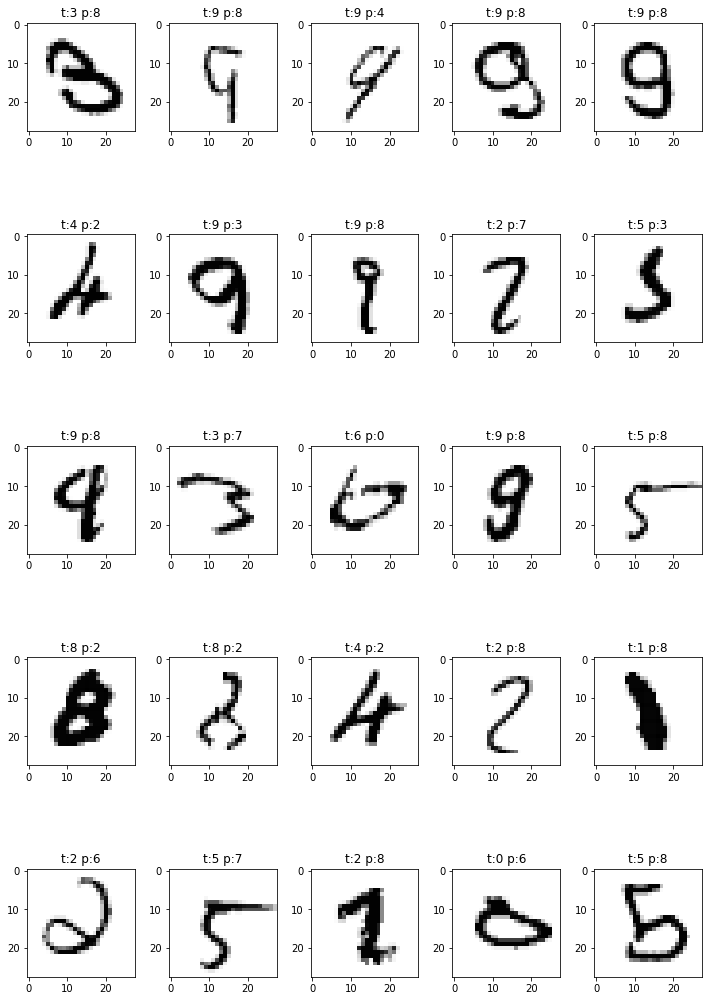

In [45]:
fig, _ = plt.subplots(5, 5, figsize = (10, 15))
for i, ax in enumerate(fig.axes):
    index = wrong_idx[i]
    ax.imshow(X_test[index, :].reshape(28, 28), cmap = "Greys")
    ax.set_title("t:" +  str(y_test[index])
                            + " p:" +  str(y_test_pred[index]))
    
plt.tight_layout()

In [46]:
len(wrong_idx)

313